# Строим графики от авторов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def plot_log_data(df):
    """Plots a log-log graph from a given DataFrame."""
    # Extract columns
    time = df["time"]
    pressure = df["atm"]
    derivative = df["der_atm"]
    
    # Create log-log plot
    plt.figure(figsize=(8, 6))
    plt.loglog(time, pressure, 'o', label='Давление')
    plt.loglog(time, derivative, 's', label='Производная давления')
    
    # Labels and title
    plt.xlabel("Время (часы)")
    plt.ylabel("Давление и производная (атм)")
    plt.title("График давления и производной во времени")
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    # Show plot
    plt.show()


In [5]:
test = pd.read_parquet('E:/DS/data/siam/bi/test_meas.parquet')

In [6]:
test[test.file_name=='00950953-2e3b-4e38-91cb-5bbdd5dbda0e']

,file_name,time,atm,der_atm
0,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,0.155730,3.762312,5.678179
1,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,0.189730,4.508152,4.686962
2,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,0.222730,5.804305,5.854821
3,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,0.255730,6.138593,6.969295
4,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,0.289730,7.318060,7.049870
...,...,...,...,...
105,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,250.339563,138.743547,78.299472
106,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,256.339563,140.709852,80.186100
107,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,262.339563,141.608644,89.769276
108,00950953-2e3b-4e38-91cb-5bbdd5dbda0e,271.339563,143.929735,103.311969


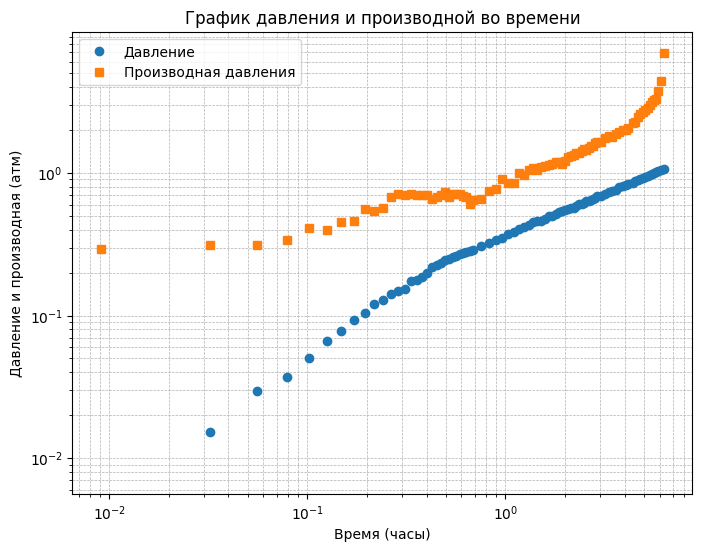

In [11]:
plot_log_data(test_rs[test_rs.file_name=='00950953-2e3b-4e38-91cb-5bbdd5dbda0e'])

# Свои графики

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth_and_plot(df, save_path, pressure_type='ma', derivative_type='fd', save_plot=True):
    """
    Function to smooth the pressure and derivative pressure time-series data,
    create log-log plots of both pressure and derivative, and optionally save the plot as an image.
    
    Parameters:
        time (pd.Series): The time series data.
        pressure (pd.Series): The pressure time series data.
        derivative_pressure (pd.Series): The derivative of pressure.
        save_path (str): Path where the plot image will be saved (if save_plot=True).
        pressure_type (str): Type of smoothing for pressure ('ma', 'gaussian', 'sg', 'lowess').
        derivative_type (str): Type of derivative computation ('fd', 'sd', 'cd_log').
        save_plot (bool): Whether to save the plot as an image (default=True). If False, it will just display the plot.
    """
    time = df["time"]
    pressure = df["atm"]
    derivative_pressure = df["der_atm"]
    file_name = df.file_name.head(1).item()
    
    # Smoothing Techniques for Pressure
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    def gaussian_smoothing(data, sigma=1):
        return gaussian_filter1d(data, sigma=sigma)

    def savitzky_golay_smoothing(data, window_length=51, polyorder=3):
        return savgol_filter(data, window_length=window_length, polyorder=polyorder)

    def lowess_smoothing(time, data, frac=0.1):
        smoothed = lowess(data, time, frac=frac)
        return smoothed[:, 1]

    # Apply smoothing to pressure
    if pressure_type == 'ma':
        smoothed_pressure = moving_average(pressure, window_size=5)
    elif pressure_type == 'gaussian':
        smoothed_pressure = gaussian_smoothing(pressure, sigma=2)
    elif pressure_type == 'sg':
        smoothed_pressure = savitzky_golay_smoothing(pressure)
    elif pressure_type == 'lowess':
        smoothed_pressure = lowess_smoothing(time, pressure)
    elif pressure_type == 'origin':
        smoothed_pressure = pressure 
    else:
        raise ValueError("Invalid pressure smoothing type. Choose from 'ma', 'gaussian', 'sg', 'lowess'.")

    # Derivative Calculation Methods
    def finite_difference_derivative(time, pressure):
        return np.gradient(pressure, time)

    def smoothed_derivative(time, pressure, window_length=51, polyorder=3):
        smoothed_pressure = savitzky_golay_smoothing(pressure, window_length, polyorder)
        return np.gradient(smoothed_pressure, time)

    def central_difference_logscale_derivative(time, pressure):
        dt = np.gradient(np.log(time))
        dp = np.gradient(pressure)
        return dp * time / dt

    # Apply chosen derivative method
    if derivative_type == 'fd':
        derivative = finite_difference_derivative(time, pressure)
    elif derivative_type == 'sd':
        derivative = smoothed_derivative(time, pressure)
    elif derivative_type == 'cd_log':
        derivative = central_difference_logscale_derivative(time, pressure)
    elif derivative_type == 'origin':
        derivative = derivative_pressure 
    else:
        raise ValueError("Invalid derivative type. Choose from 'fd', 'sd', 'cd_log'.")

    # Plotting both pressure and its derivative on the same plot (log-log scale)
    plt.figure(figsize=(10, 6))

    # Plot original and smoothed pressure
    #plt.loglog(time, pressure, label='Original Pressure', color='blue', alpha=0.5)
    plt.loglog(time[:len(smoothed_pressure)], smoothed_pressure, label=f'{pressure_type.capitalize()} Smoothing', color='green')

    # Plot original and computed derivative
    #plt.loglog(time, derivative_pressure, label='Original Derivative of Pressure', color='orange', alpha=0.5)
    plt.loglog(time, derivative, label=f'{derivative_type.capitalize()} Derivative', color='red')
    
    plt.title("Smoothed Pressure and Derivative of Pressure (Log-Log Scale)")
    plt.xlabel("Time")
    plt.ylabel("Pressure / Derivative of Pressure")
    plt.legend()
    plt.grid(True)

    # If save_plot is True, save the plot as an image
    if save_plot:
        plt.tight_layout()
        plt.savefig(f'{save_path}/{file_name}.png')
        #print(f"Plot saved to {save_path}")
    else:
        # Just display the plot if save_plot is False
        plt.show()

    # Close the plot after saving or showing
    plt.close()

# Example usage:
# Assuming you have 'time', 'pressure', 'derivative_pressure' data ready and a save path
# smooth_and_plot(time, pressure, derivative_pressure, "/path/to/save/directory", pressure_type='sg', derivative_type='sd', save_plot=True)

# Example to just display the plot without saving
# smooth_and_plot(time, pressure, derivative_pressure, "/path/to/save/directory", pressure_type='ma', derivative_type='fd', save_plot=False)


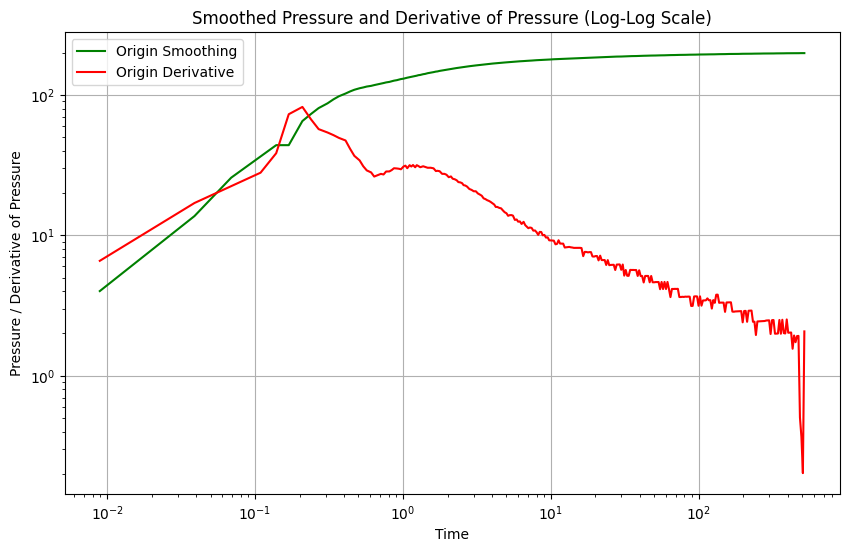

In [7]:
smooth_and_plot(test[test.file_name==a], '', pressure_type='origin', derivative_type='origin', save_plot=False)

# Код для генерации разных сглажиавний и производных

In [3]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
from statsmodels.nonparametric.smoothers_lowess import lowess

def smooth_and_compute_derivative(df,window_length =51, polyorder =3):
    """
    Function to smooth the pressure and derivative pressure time-series data using all smoothing and derivative methods, 
    and add new columns to the DataFrame with the smoothed data and derivatives.
    
    Parameters:
        df (pd.DataFrame): The DataFrame containing 'time', 'pressure', and 'derivative_pressure' columns.
    
    Returns:
        pd.DataFrame: The DataFrame with added columns for smoothed pressure and derivatives for all methods.
    """
    
    time = df['time']
    pressure = df['atm']
    derivative_pressure = df['der_atm']
    if len(df)<51:
        window_length = len(df)
    if polyorder>=window_length:
        polyorder=window_length-1
        
    
    # Smoothing Techniques for Pressure
    def moving_average(data, window_size):
        return np.convolve(data, np.ones(window_size) / window_size, mode='valid')

    def gaussian_smoothing(data, sigma=1):
        return gaussian_filter1d(data, sigma=sigma)

    def savitzky_golay_smoothing(data, window_length=window_length, polyorder=polyorder):
        return savgol_filter(data, window_length=window_length, polyorder=polyorder)

    def lowess_smoothing(time, data, frac=0.1):
        smoothed = lowess(data, time, frac=frac)
        return smoothed[:, 1]

    # Derivative Calculation Methods
    def finite_difference_derivative(time, pressure):
        return np.gradient(pressure, time)

    def smoothed_derivative(time, pressure, window_length=window_length, polyorder=polyorder):
        smoothed_pressure = savitzky_golay_smoothing(pressure, window_length, polyorder)
        return np.gradient(smoothed_pressure, time)

    def central_difference_logscale_derivative(time, pressure):
        dt = np.gradient(np.log(time))
        dp = np.gradient(pressure)
        return dp * time / dt
    if len(df)>1:
        # Apply smoothing to pressure (all types)
        smoothed_pressure_ma = moving_average(pressure, window_size=5)
        smoothed_pressure_gaussian = gaussian_smoothing(pressure, sigma=2)
        #print(window_length,polyorder)
        smoothed_pressure_sg = savitzky_golay_smoothing(pressure, window_length=window_length, polyorder=polyorder)
        smoothed_pressure_lowess = lowess_smoothing(time, pressure)
    
        # Apply derivative methods (all types)
        derivative_fd = finite_difference_derivative(time, pressure)
        derivative_sd = smoothed_derivative(time, pressure, window_length=window_length, polyorder=polyorder)
        derivative_cd_log = central_difference_logscale_derivative(time, pressure)
        

        # Add new columns to the DataFrame for all smoothed pressure and derivatives
        df['smoothed_pressure_ma'] = np.pad(smoothed_pressure_ma, (0, len(df) - len(smoothed_pressure_ma)), mode='edge')
        df['smoothed_pressure_gaussian'] = np.pad(smoothed_pressure_gaussian, (0, len(df) - len(smoothed_pressure_gaussian)), mode='edge')
        df['smoothed_pressure_sg'] = np.pad(smoothed_pressure_sg, (0, len(df) - len(smoothed_pressure_sg)), mode='edge')
        df['smoothed_pressure_lowess'] = np.pad(smoothed_pressure_lowess, (0, len(df) - len(smoothed_pressure_lowess)), mode='edge')
    
        df['derivative_fd'] = np.pad(derivative_fd, (0, len(df) - len(derivative_fd)), mode='edge')
        df['derivative_sd'] = np.pad(derivative_sd, (0, len(df) - len(derivative_sd)), mode='edge')
        df['derivative_cd_log'] = np.pad(derivative_cd_log, (0, len(df) - len(derivative_cd_log)), mode='edge')
    else:
        df['smoothed_pressure_ma']=0
        df['smoothed_pressure_gaussian']=0
        df['smoothed_pressure_sg']=0
        df['smoothed_pressure_lowess']=0
        df['derivative_fd']=0
        df['derivative_sd']=0
        df['derivative_cd_log']=0
    return df

# Example usage:
# Assuming you have a DataFrame `df` with 'time', 'pressure', and 'derivative_pressure' columns
# df = smooth_and_compute_derivative(df)


In [99]:
cc = test[test.file_name=='00950953-2e3b-4e38-91cb-5bbdd5dbda0e']

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [100]:
%%time
cc = smooth_and_compute_derivative(cc)

CPU times: total: 15.6 ms
Wall time: 16 ms


In [108]:
un_ids = test.file_name.unique()

In [122]:
new_test = []
for uuid in un_ids:
    cc = test[test.file_name==uuid]
    cc = smooth_and_compute_derivative(cc)
    new_test.append(cc)
new_test = pd.concat(new_test)

In [106]:
test.file_name.value_counts()

file_name
147a0303-014c-4ad3-adbb-0679b9816b82    1851
5c50201b-6445-49a1-8e8c-9402749854ca    1526
61fbe25b-2b93-4e35-bebf-9f05b28779ee     722
81b585eb-532c-478a-9a95-68c89e2787b4     693
3088dbdd-c980-4835-a6ab-997ce8d0c25e     597
                                        ... 
d3421fe4-5c16-481c-8ec1-845b59cae9e0       3
106fb7c4-3d9f-43c7-8401-f08e2b02a921       1
3712e002-6e62-4d87-aa44-9d25817e2004       1
287db032-b8aa-4608-b389-2fe60f0a6a54       1
846291a2-6475-47ac-8f10-08eac6b93fcb       1
Name: count, Length: 500, dtype: int64

In [124]:
new_test.describe()

,time,atm,der_atm,smoothed_pressure_ma,smoothed_pressure_gaussian,smoothed_pressure_sg,smoothed_pressure_lowess,derivative_fd,derivative_sd,derivative_cd_log
count,79042.000000,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04,7.904200e+04
mean,96.937459,1.252793e+04,2.306339e+03,1.267891e+04,1.252793e+04,1.253099e+04,1.252224e+04,1.537771e+04,1.480789e+04,1.355195e+05
std,354.703714,1.000603e+05,2.791532e+04,1.008991e+05,1.000426e+05,1.000598e+05,9.995991e+04,2.833488e+05,2.688222e+05,2.048223e+06
min,0.000011,3.234952e-04,8.626791e-05,0.000000e+00,0.000000e+00,-1.092720e+04,-1.178097e+00,-2.333560e+05,-4.032586e+06,-5.338110e+05
25%,1.463325,1.081356e+01,1.958375e+00,1.149160e+01,1.088666e+01,1.088698e+01,1.083278e+01,5.123203e-02,5.958817e-02,3.812278e+00
50%,11.747529,3.557671e+01,6.169643e+00,3.647108e+01,3.558352e+01,3.565409e+01,3.556310e+01,4.329581e-01,4.916724e-01,5.684591e+01
75%,64.338869,8.672769e+01,1.797883e+01,8.840990e+01,8.669406e+01,8.673467e+01,8.674621e+01,5.532607e+00,6.178167e+00,5.860682e+02
max,9796.000000,2.160217e+06,1.093242e+06,2.160003e+06,2.159899e+06,2.159795e+06,2.159882e+06,2.031930e+07,1.436239e+07,6.566944e+07


In [125]:
new_test.isna().sum()

file_name                     0
time                          0
atm                           0
der_atm                       0
smoothed_pressure_ma          0
smoothed_pressure_gaussian    0
smoothed_pressure_sg          0
smoothed_pressure_lowess      0
derivative_fd                 0
derivative_sd                 0
derivative_cd_log             0
dtype: int64

## подготовим альтернативные сглаживания и производные

In [126]:
from tqdm import tqdm

In [130]:
import os

In [131]:

un_ids = os.listdir('E:/DS/data/siam/bi/train/')

In [127]:
train = pd.read_parquet('E:/DS/data/siam/bi/train_meas.parquet')

In [128]:
un_ids = train.file_name.unique()

In [140]:
new_train = []
errors = []
for uuid in tqdm(un_ids, total = len(un_ids)):
    file_path = os.path.join('E:/DS/data/siam/bi/train/', uuid)
    if os.path.isfile(file_path):
        # Read the CSV file without a header and with tab as the separator
        try:
            df = pd.read_csv(file_path, sep='\t', header=None)
    
            # Ensure the file has exactly 3 columns (time, atm, der_atm)
    
            # Assign column names to the DataFrame
            df.columns = ['time', 'atm', 'der_atm']
    
            # Add a new column for the file name
            df['file_name'] = uuid
    
            # Reorder columns to match the desired output format
            df = df[['file_name', 'time', 'atm', 'der_atm']]
            cc = df
            try:
                cc = smooth_and_compute_derivative(cc)
                new_train.append(cc)
            except:
                errors.append(uuid)
        except:
            errors.append(uuid)                
new_train = pd.concat(new_train)

100%|████████████████████████████████████████████████████████████████████████████| 45141/45141 [21:49<00:00, 34.46it/s]


In [145]:
len(errors)

332

In [141]:
new_train.describe()

,time,atm,der_atm,smoothed_pressure_ma,smoothed_pressure_gaussian,smoothed_pressure_sg,smoothed_pressure_lowess,derivative_fd,derivative_sd,derivative_cd_log
count,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450291e+06,8.450115e+06
mean,1.047740e+02,1.098560e+26,1.538404e+25,1.108552e+26,1.098560e+26,1.099158e+26,1.112726e+26,9.180014e+25,9.033633e+25,5.862241e+26
std,1.808394e+03,1.807096e+28,3.163218e+27,1.820474e+28,1.806788e+28,1.807766e+28,1.817742e+28,6.154411e+28,5.907448e+28,2.207650e+29
min,-5.561043e+02,2.564978e-07,5.039755e-13,0.000000e+00,0.000000e+00,-3.263002e+05,-1.384848e+05,-2.375855e+07,-4.585329e+28,-1.532981e+09
25%,9.083333e-01,1.212583e+01,2.378922e+00,1.264083e+01,1.217117e+01,1.216526e+01,1.214141e+01,1.110449e-01,1.308368e-01,3.361554e+00
50%,7.300000e+00,3.823615e+01,7.674474e+00,3.913066e+01,3.825940e+01,3.827316e+01,3.822085e+01,9.278012e-01,1.037269e+00,5.198626e+01
75%,4.397588e+01,1.126225e+02,2.418928e+01,1.142728e+02,1.126223e+02,1.125673e+02,1.125531e+02,1.254890e+01,1.422721e+01,5.995373e+02
max,8.429354e+05,4.647122e+30,1.324309e+30,4.595379e+30,4.616909e+30,4.647281e+30,4.667284e+30,6.696182e+31,6.355187e+31,1.645891e+32


In [144]:
new_test.to_parquet('E:/DS/data/siam/bi/test_meas_adv.parquet', index=False)
new_train.fillna(0).to_parquet('E:/DS/data/siam/bi/train_meas_adv.parquet', index=False)

In [3]:
import os
from tqdm import tqdm

In [14]:
#new_train = []
un_ids = test.file_name.unique()
errors = []
for uuid in tqdm(un_ids, total = len(un_ids)):
    file_path = os.path.join('E:/DS/data/siam/bi/test/', uuid)
    if os.path.isfile(file_path):
        # Read the CSV file without a header and with tab as the separator
        try:
            df = pd.read_csv(file_path, sep='\t', header=None)
    
            # Ensure the file has exactly 3 columns (time, atm, der_atm)
    
            # Assign column names to the DataFrame
            df.columns = ['time', 'atm', 'der_atm']
    
            # Add a new column for the file name
            df['file_name'] = uuid
    
            # Reorder columns to match the desired output format
            df = df[['file_name', 'time', 'atm', 'der_atm']]
            cc = df
            try:
                smooth_and_plot(cc, 'E:/DS/data/siam/plots/test/', pressure_type='origin', derivative_type='origin', save_plot=True)
                #new_train.append(cc)
            except:
                errors.append(uuid)
        except:
            errors.append(uuid)                

100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [04:50<00:00,  1.72it/s]


In [15]:
print(len(errors))

1


In [16]:
errors

['846291a2-6475-47ac-8f10-08eac6b93fcb']

In [17]:
len(un_ids)

500

In [23]:
dev_ids = pd.read_csv('E:/DS/data/siam/bi/tgs/deb1k_df_woo_r_sc_f_adv.csv')

In [25]:
dev_ids.file_name.nunique()

1000

In [26]:
#new_train = []
un_ids = dev_ids.file_name.unique()
errors = []
for uuid in tqdm(un_ids, total = len(un_ids)):
    file_path = os.path.join('E:/DS/data/siam/bi/train/', uuid)
    if os.path.isfile(file_path):
        # Read the CSV file without a header and with tab as the separator
        try:
            df = pd.read_csv(file_path, sep='\t', header=None)
    
            # Ensure the file has exactly 3 columns (time, atm, der_atm)
    
            # Assign column names to the DataFrame
            df.columns = ['time', 'atm', 'der_atm']
    
            # Add a new column for the file name
            df['file_name'] = uuid
    
            # Reorder columns to match the desired output format
            df = df[['file_name', 'time', 'atm', 'der_atm']]
            cc = df
            try:
                smooth_and_plot(cc, 'E:/DS/data/siam/plots/deb/', pressure_type='origin', derivative_type='origin', save_plot=True)
                #new_train.append(cc)
            except:
                errors.append(uuid)
        except:
            errors.append(uuid)                

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [09:53<00:00,  1.68it/s]


In [28]:
len(errors)

0

In [ ]:
#dev_ids[~dev_ids.file_name.isin(errors)].to_csv('E:/DS/data/siam/bi/tgs/deb1k_CV.csv', index=False)

# Код для генерации и сохранения графиков как картинок
пришлось несколько запусков делать, гдето утекает память

In [2]:
import os
from tqdm import tqdm

In [3]:
train = pd.read_parquet('E:/DS/data/siam/bi/train_meas.parquet')

In [4]:
un_ids = train.file_name.unique()

In [5]:
del train
import gc
gc.collect()

0

In [6]:
start = 9751+686+5532+ 8315+5000+5000+5000

In [7]:
print(start)

39284


In [8]:
#new_train = []
#un_ids = train.file_name.unique()
errors = []
for uuid in tqdm(un_ids[start:], total = len(un_ids[start:])):
    #gc.collect()
    file_path = os.path.join('E:/DS/data/siam/bi/train/', uuid)
    if os.path.isfile(file_path):
        # Read the CSV file without a header and with tab as the separator
        try:
            df = pd.read_csv(file_path, sep='\t', header=None)
    
            # Ensure the file has exactly 3 columns (time, atm, der_atm)
    
            # Assign column names to the DataFrame
            df.columns = ['time', 'atm', 'der_atm']
    
            # Add a new column for the file name
            df['file_name'] = uuid
    
            # Reorder columns to match the desired output format
            df = df[['file_name', 'time', 'atm', 'der_atm']]
            cc = df
            try:
                smooth_and_plot(cc, 'E:/DS/data/siam/plots/train/', pressure_type='origin', derivative_type='origin', save_plot=True)
                #new_train.append(cc)
            except:
                errors.append(uuid)
        except:
            errors.append(uuid)                

100%|██████████████████████████████████████████████████████████████████████████████| 5600/5600 [57:32<00:00,  1.62it/s]
